In [2]:
from dataclasses import dataclass
import torch
import matplotlib.pyplot as plt
import networkx as nx
import torch_geometric
from torch_geometric.data import Data

from datasets.tu import TUDataModule, TULetterLowConfig, TUFingerprintConfig
from datasets.mnist import MnistDataModule
from datasets.config import MnistDataModuleConfig, GNNBenchmarkDataModuleConfig
from datasets.gnn_benchmark import GNNBenchmarkDataModule

from reconstruction.recon_2d import reconstruct_ect

NUM_STEPS = 512
NUM_PTS = 15
SCALE = 400


def compute_ect(x, v, ei=None):
    nh = x @ v
    lin = torch.linspace(-1.3, 1.3, NUM_STEPS).view(-1, 1, 1)
    ecc = torch.nn.functional.sigmoid(SCALE * torch.sub(lin, nh)) * (
        1 - torch.nn.functional.sigmoid(SCALE * torch.sub(lin, nh))
    )
    ecc = ecc.sum(axis=1)
    if ei is not None:
        eh = nh[ei].mean(axis=0)
        eccedge = torch.nn.functional.sigmoid(SCALE * torch.sub(lin, eh)) * (
            1 - torch.nn.functional.sigmoid(SCALE * torch.sub(lin, eh))
        )
        eccedge = eccedge.sum(axis=1)
        ecc -= eccedge
    return ecc


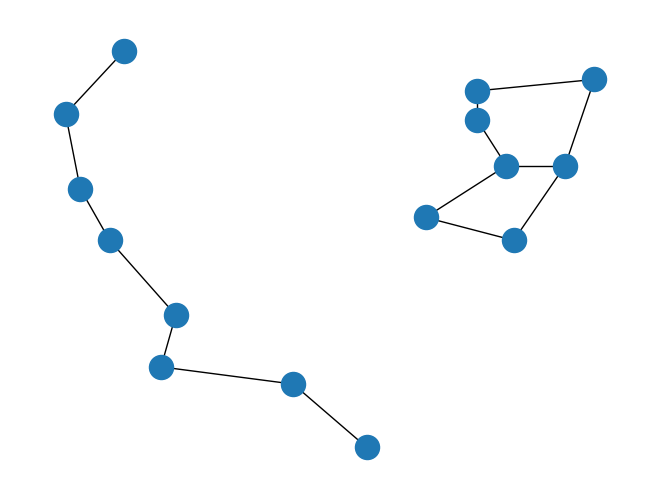

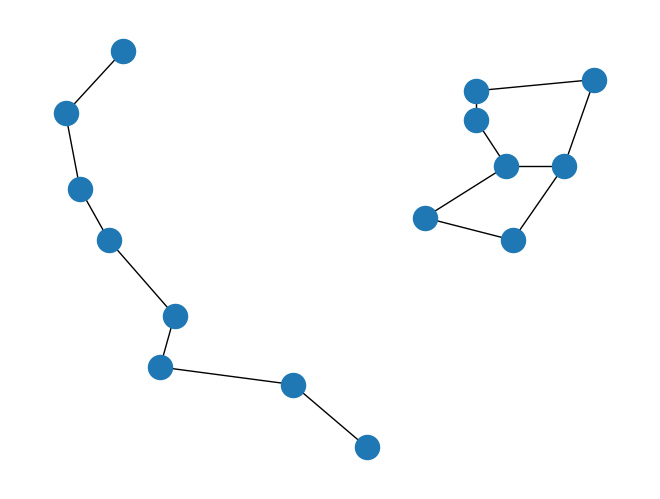

In [36]:
dataset = TUDataModule(TUFingerprintConfig())
data = dataset.test_ds[1]
x = data.x[:,:2]

ei = data.edge_index
g = torch_geometric.utils.to_networkx(data, to_undirected=True)
nx.draw(g, pos=x.numpy())
plt.show()

v = torch.vstack(
    [
        torch.sin(torch.linspace(0, 2 * torch.pi, NUM_STEPS)),
        torch.cos(torch.linspace(0, 2 * torch.pi, NUM_STEPS)),
    ]
)

ect = compute_ect(x, v, ei=ei)
x_hat, edge_index_recon = reconstruct_ect(ect,v)

data_recon = Data(x=x_hat, edge_index=edge_index_recon)
g = torch_geometric.utils.to_networkx(data_recon, to_undirected=True)
nx.draw(g, pos=data_recon.x.numpy())
plt.show()

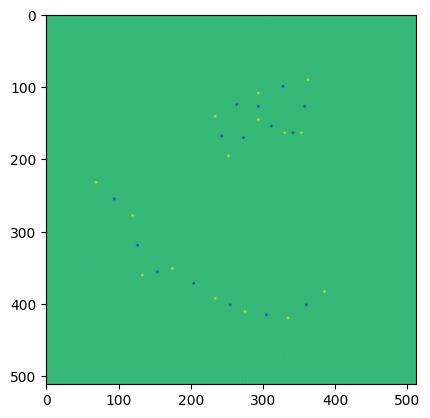

In [37]:
from reconstruction.recon_2d import fbp, get_node_coordinates, get_edge_indices
reconstruction_fbp = fbp(ect)
# x_hat = get_node_coordinates(reconstruction_fbp)
# edge_index_recon = get_edge_indices(reconstruction_fbp, x_hat, v)


plt.imshow(reconstruction_fbp)
